# Spotify Playlist Prediction
**Kevin Yoon, Madeleine Nakada, Michelle Xie**

*Something here about what we're doing*

## Import Libraries

In [1]:
import pandas as pd
import json
import random
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import requests
import pprint
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import csv
# import sklearn.linear_model

In [2]:
random.seed(112358)

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from keras import regularizers


from sklearn.utils import shuffle

Using TensorFlow backend.


In [3]:
pp = pprint.PrettyPrinter(indent=4)

In [4]:
#from spotify import get_features

In [5]:
import config
import base64

## Building the Data Set

We need to get additional information from Spotify since playlists only give us basic information like song title and artist. We make calls to 3 APIs for each song, which is slow so we've stored the information we need about songs we've already seen.

In [6]:
def get_token():
    cred = config.api_key
    byte =  cred.encode("utf-8")
    # b64Val = base64.b64encode(byte)
    b64 = base64.urlsafe_b64encode(cred.encode()).decode()
    auth = {'Authorization': 'Basic ' + b64}
    payload = {"grant_type": "client_credentials"}
    response = requests.post("https://accounts.spotify.com/api/token", 
        data=payload, headers=auth)
    return response.json()['access_token']
token = get_token()

base_url = "https://api.spotify.com/v1"
headers = {'Authorization': 'Bearer ' + token}


In [7]:
def get_features(songs):
    url = base_url + '/audio-features'
    i = 0
    features = []
    while i < len(songs):
        current = songs[i:i+100]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        features = features + data["audio_features"]
        i = i + 100
    return features

In [8]:
def get_genres(artists):
    genres = Counter()
    url = base_url + '/artists'
    i = 0
    genre_list = []
    while i < len(artists):
        current = artists[i:i+10]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for artist in data['artists']:
            for genre in artist['genres']:
                genres[genre] += 1
            genre_list.append(artist['genres'])
        i = i + 10
    return genres, genre_list

In [9]:
def get_years(albums):
    years = Counter()
    years_list = []
    url = base_url + '/albums'
    i = 0
    while i < len(albums):
        current = albums[i:i+20]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for album in data['albums']:
            date = album['release_date']
            year = date.split('-')[0]
            years[year] += 1
            years_list.append(year)
        i = i + 20
    return years, years_list

In [10]:
def get_popularity(songs):
    popularity = []
    url = base_url + '/tracks'
    i = 0
    while i < len(songs):
        current = songs[i:i+50]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for track in data['tracks']:
            popularity.append(track['popularity'])
        i = i + 50
    return popularity

Create a progress bar function since getting the data can be slow and we want to make sure the program is still running. Also tracks number of failures for getting features which later we could troubleshoot but for now we're avoiding.

In [11]:
def progress_bar(index, total, failures):
    clear_output(wait=True)
    percent = index/total
    bars = "#" * int(percent * 30)
    lines = "-" * int((1-percent) * 30)
    display("|" + bars + lines + "| (%d/%d) with %d failures"%(index,total, failures))

Randomly select a set of 1000 playlists from the Million Playlist Dataset (this is easier than actually selecting 1000 playlists individually from such a massive data set) and extract the playlist information.

In [12]:
# add some code here to randomize selection

In [13]:
path = './mpd.slice.0-999.json'

with open(path) as infile:
    data = json.load(infile)
playlists = pd.DataFrame(data['playlists'])
playlists.set_index("pid")
playlists.shape

(1000, 12)

Add columns for our features which we get using the **get_features** function

In [14]:
feature_names = ["acousticness", "danceability","duration_ms",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "year", "popularity","genre"]
for feature in feature_names:
    playlists[feature] = None

In [15]:
playlists.head()

collaborative description duration_ms  modified_at              name  num_albums  num_artists  num_edits  num_followers  num_tracks  pid                                             tracks acousticness danceability energy instrumentalness   key liveness loudness  mode speechiness time_signature tempo valence  year popularity genre
0         false         NaN        None   1493424000        Throwbacks          47           37          6              1          52    0  [{'album_name': 'The Cookbook', 'track_name': ...         None         None   None             None  None     None     None  None        None           None  None    None  None       None  None
1         false         NaN        None   1506556800  Awesome Playlist          23           21          5              1          39    1  [{'album_name': 'Eye Of The Tiger', 'track_nam...         None         None   None             None  None     None     None  None        None           None  None    None  None       None  None
2         false         NaN        None   1505692800           korean           51           31         18              1          64    2  [{'album_name': 'On And On', 'track_name': 'Li...         None         None   None             None  None     None     None  None        None           None  None    None  None       None  None
3         false         NaN        None   1501027200               mat         107           86          4              1         126    3  [{'album_name': 'French Festival', 'track_name...         None         None   None             None  None     None     None  None        None           None  None    None  None       None  None
4         false         NaN        None   1401667200               90s          16           16          7              2          17    4  [{'album_name': 'Mellon Collie and the Infinit...         None         None   None             None  None     None     None  None        None           None  None    None  None       None  None

Get the features for each playlist (with our progress bar!)

In [16]:
with open('./songs/feature_data.txt', 'r') as infile:
    feature_data = eval(infile.read())
with open('./songs/genre_data.txt', 'r') as infile:
    genre_data = eval(infile.read())
with open('./songs/year_data.txt', 'r') as infile:
    year_data = eval(infile.read())
with open('./songs/popularity_data.txt', 'r') as infile:
    popularity_data = eval(infile.read())


In [17]:
len(feature_data)

30353

In [18]:
failures = 0
# iterate over all playlists
for index, row in playlists.iterrows():
    # render progress bar
    progress_bar(index + 1,playlists.shape[0], failures)
    # initialize all values to 0
    features = {
        "acousticness": 0,
        "danceability": 0,
        "duration_ms" : 0,
        "energy" : 0,
        "instrumentalness" : 0,
        "key" : 0,
        "liveness" : 0,
        "loudness" : 0,
        "mode" : 0,
        "speechiness" : 0,
        "time_signature" : 0,
        "tempo" : 0,
        "valence" : 0,
    }
    artists = set({})
    albums = set({})
    
#     artists = Counter()
#     counters = set(["artists"])
    all_features = set(features.keys())

    # get tracks for playlist
    tracks = row["tracks"]

    # seen stores the songs we've seen, songs stores new songs
    seen = []
    songs = []
    # iterate over all songs in playlist
    for track in tracks:
        track_id = track['track_uri'].split(":")[-1]
        
        # if we've seen the track, continue, otherwise get its identifiers
        if track_id in feature_data:
            seen.append(track_id)
        else:
            songs.append(track_id)
            artist_id = track['artist_uri'].split(":")[-1]
            artists.add(artist_id)
            album_id = track['album_uri'].split(":")[-1]
            albums.add(album_id)
    # get song data, either by looking up on API or in our files
    # if there's any issue with the failure we skip this row rather than
    # terminating the program
    try:
        # get information for new songs, returning counters and raw list
        song_features = get_features(songs)
        genres, genre_list = get_genres(list(artists))
        years, years_list = get_years(list(albums))
        popularity = get_popularity(songs)
        popularity_list = list(popularity)
        
        # add new songs to our database
        for song, feature, genre, year, pop in zip(songs, song_features, genre_list, years_list, popularity_list):
            feature_data[song] = feature
            genre_data[song] = genre
            year_data[song] = year
            popularity_data[song] = pop
        # add data from our seen songs
        for song in seen:
            song_features.append(feature_data[song])
            for genre in genre_data[song]:
                genres[genre] += 1
            popularity.append(popularity_data[song])
            years[year_data[song]] += 1
            
        # update popularity to be median value (not mean b/c outliers)
        popularity = np.median(popularity)
        features['popularity'] = popularity        

        # insert all information into features dict
        for song in song_features:
            for feature in all_features:

                features[feature] += song[feature]
        # average necessary values and update data table
        for feature in feature_names:
            if feature in all_features:
                features[feature] = features[feature] / len(tracks)
                if feature == "time_signature":
                    features[feature] = int(features[feature] + 0.5)
            elif feature == "year":
                features["year"] = int(years.most_common(1)[0][0])
            elif feature == "genre":
                features["genre"] = genres.most_common(1)[0][0]            
            playlists.at[index, feature] = features[feature]
    except Exception as ex:
        failures += 1



'|##############################| (1000/1000) with 2 failures'

In [19]:
# dicts= [feature_data, genre_data, year_data,popularity_data]

with open('./songs/feature_data.txt', 'w') as file:
    file.write(str(feature_data))
with open('./songs/genre_data.txt', 'w') as file:
    file.write(str(genre_data))
with open('./songs/year_data.txt', 'w') as file:
    file.write(str(year_data))
with open('./songs/popularity_data.txt', 'w') as file:
    file.write(str(popularity_data))

In [20]:

playlists.head()

collaborative description duration_ms  modified_at              name  num_albums  num_artists  num_edits  num_followers  num_tracks  pid                                             tracks acousticness danceability    energy instrumentalness      key  liveness loudness      mode speechiness time_signature    tempo   valence  year popularity genre
0         false         NaN      221777   1493424000        Throwbacks          47           37          6              1          52    0  [{'album_name': 'The Cookbook', 'track_name': ...    0.0834403     0.659288  0.782173       0.00067601  5.03846  0.192127 -4.88194  0.692308    0.107021              4  123.007  0.642904  2007         61     p
1         false         NaN      298844   1506556800  Awesome Playlist          23           21          5              1          39    1  [{'album_name': 'Eye Of The Tiger', 'track_nam...       0.1631     0.496459  0.691077          0.22227  4.46154  0.178433 -8.29167  0.538462   0.0884487              4   122.67  0.476667  1981         59     o
2         false         NaN      219375   1505692800           korean           51           31         18              1          64    2  [{'album_name': 'On And On', 'track_name': 'Li...      0.26923     0.671875  0.693203      0.000637814        5  0.169028 -4.87416  0.515625   0.0962875              4  114.601  0.565078  2017         48     p
3         false         NaN      229575   1501027200               mat         107           86          4              1         126    3  [{'album_name': 'French Festival', 'track_name...      0.27387     0.513714  0.621282         0.202042  5.10317  0.188585 -9.61494  0.714286   0.0671857              4  125.032  0.451623  2015         34     o
4         false         NaN      255014   1401667200               90s          16           16          7              2          17    4  [{'album_name': 'Mellon Collie and the Infinit...     0.177148     0.576765  0.650535        0.0818755  3.35294  0.166524 -7.63447  0.823529   0.0411588              4   127.76  0.490765  1997         49     r

In [21]:
features = {
        "acousticness": 0,
        "danceability": 0,
        "duration_ms" : 0,
        "energy" : 0,
        "instrumentalness" : 0,
        "key" : 0,
        "liveness" : 0,
        "loudness" : 0,
        "mode" : 0,
        "speechiness" : 0,
        "time_signature" : 0,
        "tempo" : 0,
        "valence" : 0,
    }
for feature in list(features.keys()):
    playlists[feature] = pd.to_numeric(playlists[feature])

playlists[list(features.keys())].describe()

loudness       tempo  instrumentalness     valence    liveness  danceability  speechiness      energy  acousticness  time_signature         key    duration_ms        mode
count  998.000000  998.000000        998.000000  998.000000  998.000000    998.000000   998.000000  998.000000    998.000000      998.000000  998.000000     998.000000  998.000000
mean    -7.457840  121.053396          0.056627    0.491398    0.188250      0.603369     0.092966    0.630407      0.253855        3.989980    5.155304  233375.532839    0.664106
std      2.499715    7.108603          0.120874    0.123440    0.047102      0.093280     0.059301    0.134648      0.182264        0.099647    0.685701   27348.276650    0.151138
min    -30.449077   83.653125          0.000000    0.102700    0.098562      0.224467     0.030320    0.041362      0.001561        3.000000    0.571429  101610.818182    0.100000
25%     -8.340720  116.694232          0.001776    0.415734    0.162591      0.542965     0.051080    0.568575      0.129298        4.000000    4.800617  218686.745455    0.555556
50%     -6.873491  121.306305          0.013337    0.488575    0.183191      0.605306     0.074148    0.648719      0.199471        4.000000    5.150982  230886.416667    0.656451
75%     -5.860504  125.148794          0.053290    0.573700    0.204852      0.670638     0.114790    0.724076      0.319846        4.000000    5.524556  245570.362539    0.777778
max     -3.591700  153.919429          0.914923    0.898061    0.717087      0.844500     0.788188    0.934023      0.989923        4.000000    9.000000  411149.050000    1.000000

## Clean Up Data
Remove entries for which we couldn't get all song data

In [22]:
clean_data = playlists[playlists["time_signature"] > 0]
print(clean_data.shape)
clean_data.head()

(998, 27)


collaborative description    duration_ms  modified_at              name  num_albums  num_artists  num_edits  num_followers  num_tracks  pid                                             tracks  acousticness  danceability    energy  instrumentalness       key  liveness  loudness      mode  speechiness  time_signature       tempo   valence  year popularity genre
0         false         NaN  221777.461538   1493424000        Throwbacks          47           37          6              1          52    0  [{'album_name': 'The Cookbook', 'track_name': ...      0.083440      0.659288  0.782173          0.000676  5.038462  0.192127 -4.881942  0.692308     0.107021             4.0  123.006885  0.642904  2007         61     p
1         false         NaN  298844.128205   1506556800  Awesome Playlist          23           21          5              1          39    1  [{'album_name': 'Eye Of The Tiger', 'track_nam...      0.163100      0.496459  0.691077          0.222270  4.461538  0.178433 -8.291667  0.538462     0.088449             4.0  122.669615  0.476667  1981         59     o
2         false         NaN  219374.875000   1505692800           korean           51           31         18              1          64    2  [{'album_name': 'On And On', 'track_name': 'Li...      0.269230      0.671875  0.693203          0.000638  5.000000  0.169028 -4.874156  0.515625     0.096288             4.0  114.600672  0.565078  2017         48     p
3         false         NaN  229575.055556   1501027200               mat         107           86          4              1         126    3  [{'album_name': 'French Festival', 'track_name...      0.273870      0.513714  0.621282          0.202042  5.103175  0.188585 -9.614937  0.714286     0.067186             4.0  125.032413  0.451623  2015         34     o
4         false         NaN  255014.352941   1401667200               90s          16           16          7              2          17    4  [{'album_name': 'Mellon Collie and the Infinit...      0.177148      0.576765  0.650535          0.081875  3.352941  0.166524 -7.634471  0.823529     0.041159             4.0  127.759882  0.490765  1997         49     r

Select playlists with at least 20 songs

In [23]:
big_data = clean_data[clean_data["num_tracks"] > 10]
print(big_data.shape)
big_data.head()

(947, 27)


collaborative description    duration_ms  modified_at              name  num_albums  num_artists  num_edits  num_followers  num_tracks  pid                                             tracks  acousticness  danceability    energy  instrumentalness       key  liveness  loudness      mode  speechiness  time_signature       tempo   valence  year popularity genre
0         false         NaN  221777.461538   1493424000        Throwbacks          47           37          6              1          52    0  [{'album_name': 'The Cookbook', 'track_name': ...      0.083440      0.659288  0.782173          0.000676  5.038462  0.192127 -4.881942  0.692308     0.107021             4.0  123.006885  0.642904  2007         61     p
1         false         NaN  298844.128205   1506556800  Awesome Playlist          23           21          5              1          39    1  [{'album_name': 'Eye Of The Tiger', 'track_nam...      0.163100      0.496459  0.691077          0.222270  4.461538  0.178433 -8.291667  0.538462     0.088449             4.0  122.669615  0.476667  1981         59     o
2         false         NaN  219374.875000   1505692800           korean           51           31         18              1          64    2  [{'album_name': 'On And On', 'track_name': 'Li...      0.269230      0.671875  0.693203          0.000638  5.000000  0.169028 -4.874156  0.515625     0.096288             4.0  114.600672  0.565078  2017         48     p
3         false         NaN  229575.055556   1501027200               mat         107           86          4              1         126    3  [{'album_name': 'French Festival', 'track_name...      0.273870      0.513714  0.621282          0.202042  5.103175  0.188585 -9.614937  0.714286     0.067186             4.0  125.032413  0.451623  2015         34     o
4         false         NaN  255014.352941   1401667200               90s          16           16          7              2          17    4  [{'album_name': 'Mellon Collie and the Infinit...      0.177148      0.576765  0.650535          0.081875  3.352941  0.166524 -7.634471  0.823529     0.041159             4.0  127.759882  0.490765  1997         49     r

## Explore The Data

First we want to see if there are any features in which we don't see much variation, since these will likely not be helpful for prediction

In [24]:
big = 30

fig, ax=plt.subplots(13, 13, figsize=(130,130))
graphs = ax.ravel()
i = 0
for feature1 in feature_names[:13]:
    for feature2 in feature_names[:13]:
        graph = graphs[i]
        graph.scatter(clean_data[feature1], clean_data[feature2])
        graph.set_title(feature1 + " vs " + feature2, fontsize=big)
#     print(feature)
#     graph.hist(clean_data[feature], 25, histtype='stepfilled')
#     graph.set_title(feature)
#     graph.legend()
        i += 1

In [25]:
genre_counter = Counter()
for key in genre_data.keys():
#     print(genre_data[key])
    if type(genre_data[key]) == list:
        for genre in genre_data[key]:
            genre_counter[genre] += 1
    else:
        genre_counter[genre_data[key]] += 1


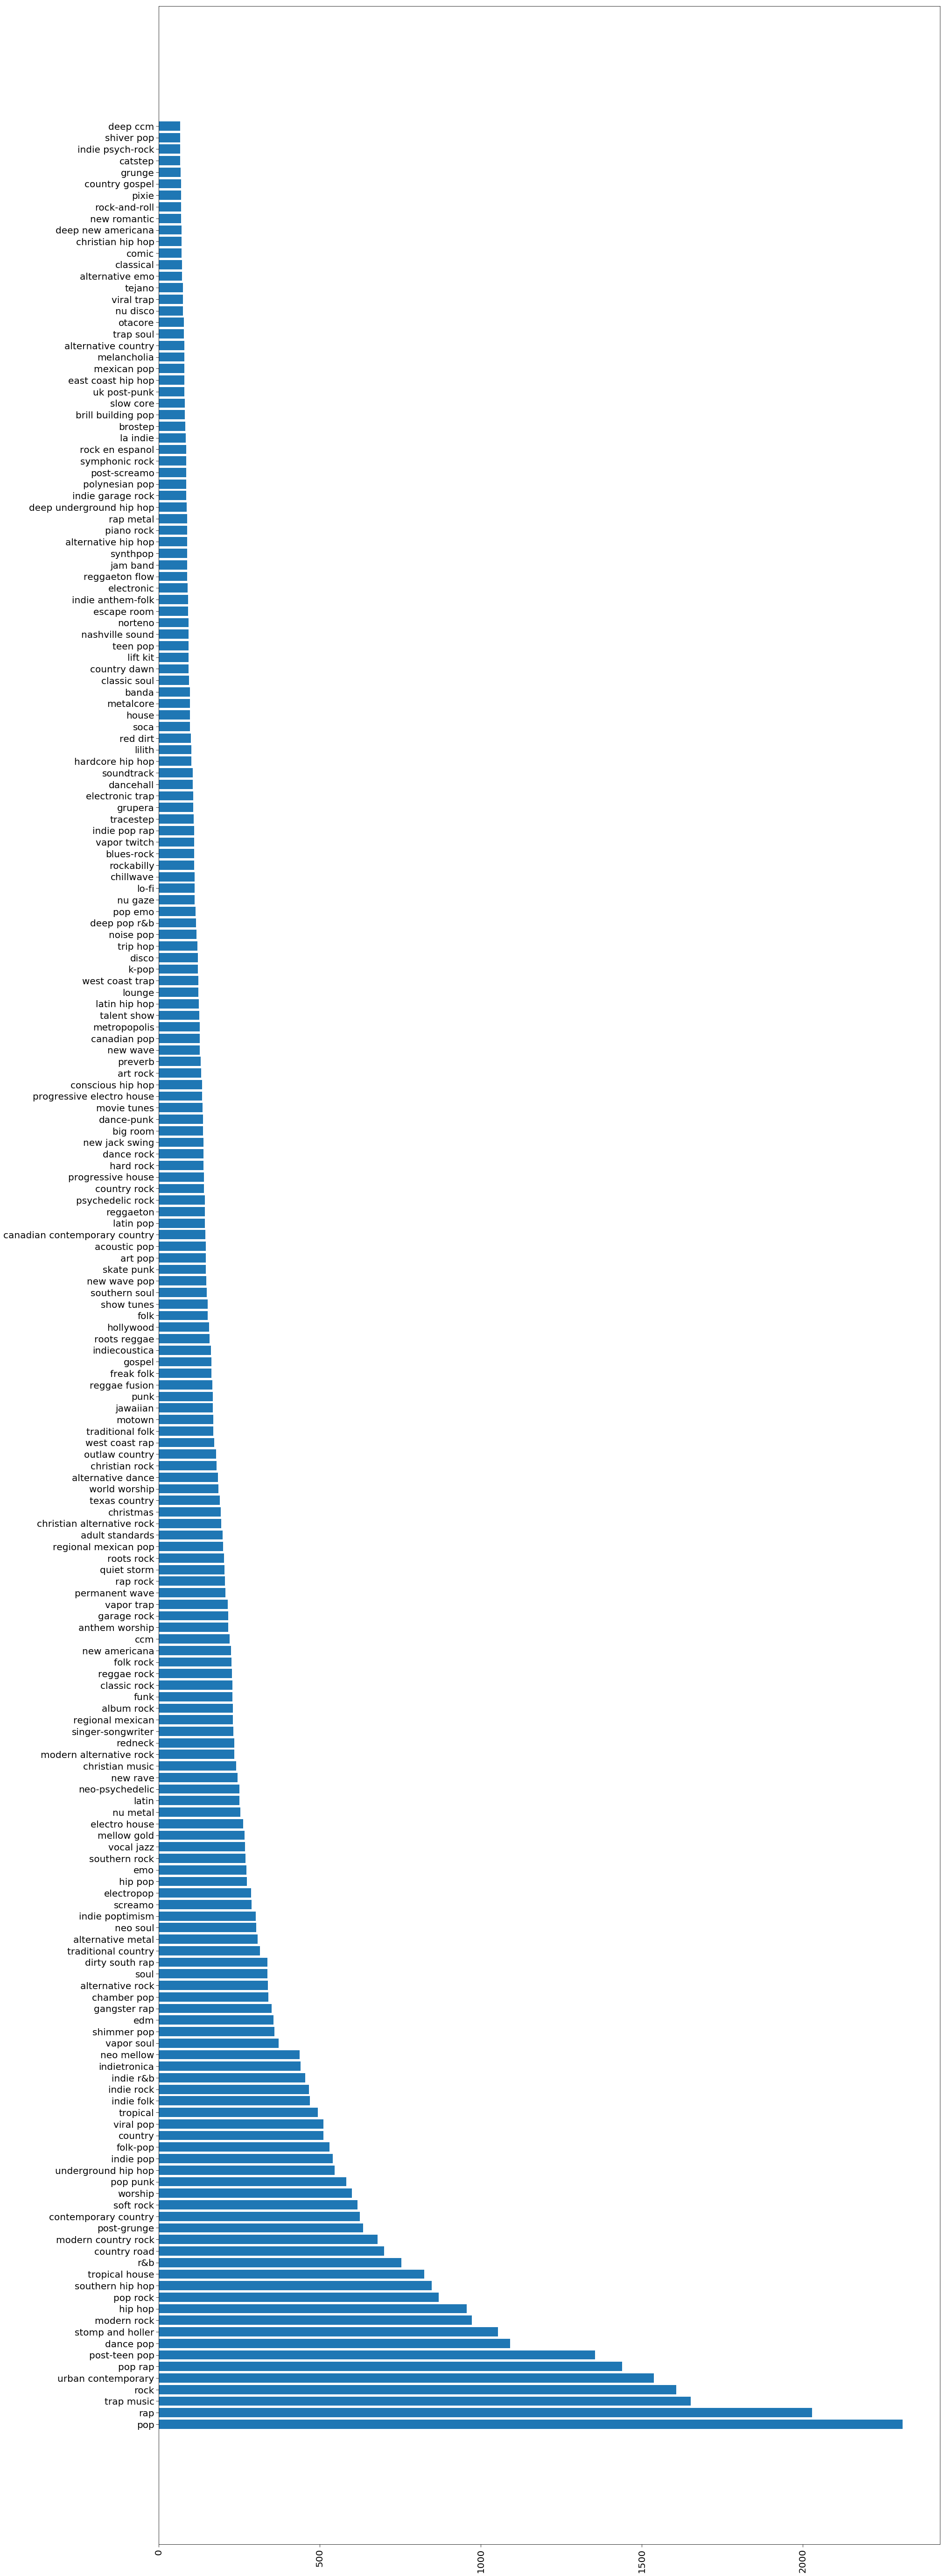

In [26]:
most = genre_counter.most_common(200)

genres = list(zip(*most))[0]
counts = list(zip(*most))[1]
x_pos = np.arange(len(genres)) 


# labels, values = zip(*genre_counter.items())
# indexes = np.arange(len(labels))
fig, ax=plt.subplots(1, 1, figsize=(30,100))
# # plt.
ax.barh(genres, counts)
plt.xticks(rotation=90)

ax.tick_params(labelsize=20, length=6)
# plt.xticks(indexes + width * 0.5, labels)
# ax.show()


Observations are in EDA write-up

## Split train and test data

In [27]:
train_data, test_data = train_test_split(big_data, test_size=0.2, random_state=42)

In [28]:
train_data.shape, test_data.shape

((757, 27), (190, 27))

In [29]:
train_data.head()

collaborative description    duration_ms  modified_at       name  num_albums  num_artists  num_edits  num_followers  num_tracks  pid                                             tracks  acousticness  danceability    energy  instrumentalness       key  liveness  loudness      mode  speechiness  time_signature       tempo   valence  year popularity genre
117         false         NaN  225814.692308   1476489600  Fall 2015          13           13          7              1          13  117  [{'album_name': 'Back To Me', 'track_name': 'B...      0.251553      0.536154  0.672538          0.001740  4.923077  0.224615 -7.074923  0.846154     0.041585             4.0  124.307692  0.628462  2015         15     o
84          false         NaN  268093.000000   1500940800   Workout2          35           26         17              1          39   84  [{'album_name': 'When It's Dark Out', 'track_n...      0.123459      0.666667  0.754051          0.014956  4.794872  0.265772 -5.514538  0.538462     0.226328             4.0  124.366872  0.473167  2003         59     r
577         false         NaN  250592.096774   1492387200      sound          26           21          6              1          31  577  [{'album_name': 'Peter, Paul & Mary: Live in J...      0.380671      0.553097  0.613935          0.005915  5.451613  0.181268 -8.820871  0.967742     0.077768             4.0  123.899387  0.580581  2009         45     o
888         false         NaN  267549.363636   1442880000   Old Rock          20           17         10              1          22  888  [{'album_name': 'Second Helping', 'track_name'...      0.248980      0.510955  0.586591          0.032800  5.045455  0.168632 -9.355091  0.818182     0.046186             4.0  113.697227  0.505136  2014       59.5     o
89          false         NaN  252306.043478   1489276800       80's          85           82          2              1          92   89  [{'album_name': 'Chinese Wall', 'track_name': ...      0.172472      0.671533  0.633152          0.032968  5.641304  0.145271 -9.562924  0.739130     0.051257             4.0  119.345674  0.668054  1982       61.5     o

In [30]:
def make_row(track_id, row):
    features = feature_data[track_id]
    for feature in features:
        if feature not in str_feature:
#                     print(feature)
            features[feature] = abs(features[feature] - row[feature])
    popularity = abs(popularity_data[track_id] - row['popularity'])
    features["popularity"] = int(popularity)
    return features

In [31]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

str_feature = set(["analysis_url", "id", "uri", "type", "track_id", "track_href"])
song_keys = feature_data.keys()
train_data_songs = pd.DataFrame([], columns=columns)
train_data_y = []
train_songs = {}
i = 1
total = train_data.shape[0]
for index, row in train_data.iterrows():
    progress_bar(i, total, 0)
    i += 1

    tracks = set([])
    for index, track in enumerate(row["tracks"]):
        if index < 10:
            track_id = track["track_uri"].split(':')[-1]
            tracks.add(track_id)
            if track_id in feature_data:
                features = make_row(track_id, row)
                train_data_songs = train_data_songs.append(features, ignore_index=True)
                train_data_y.append(1)
    other_keys = random.sample(song_keys, 30)
    for key in other_keys:
        if not key in tracks and key in feature_data:
            features = make_row(key, row)
            train_data_songs = train_data_songs.append(features, ignore_index=True)
            train_data_y.append(0)
    
train_data_songs = train_data_songs.set_index("id")


# remove = ['tracks', "collaborative", "description", "modified_at", "name", "num_edits", "num_followers", "pid"]

# train_data_y = train_data["tracks"]
# train_data_x = train_data[train_data.columns.difference(remove)]
# for index, row in train_data.iterrows():
#     random.shuffle(row["tracks"])
#     train_data_y.append(row["tracks"][-5:])
# #     train_data_x.at[index,"tracks"] = row["tracks"][:-5]

'|##############################| (757/757) with 0 failures'

In [32]:
train_data_songs.head()

acousticness  danceability    energy  instrumentalness       key  liveness  loudness      mode  speechiness  time_signature      tempo   valence popularity                                       analysis_url    duration_ms                                         track_href            type                                   uri
id                                                                                                                                                                                                                                                                                                                                                            
4s40tMs2lqA6h0HPmqPDkZ      0.243023      0.211154  0.096462          0.001740  5.076923  0.103615  3.200923  0.153846     0.003685             0.0  40.115308  0.262462         10  https://api.spotify.com/v1/audio-analysis/4s40...   16521.692308  https://api.spotify.com/v1/tracks/4s40tMs2lqA6...  audio_features  spotify:track:4s40tMs2lqA6h0HPmqPDkZ
6imjmdYzqJS03o0YrPq06V      0.213453      0.098846  0.162538          0.001730  0.923077  0.020385  3.644077  0.153846     0.012285             0.0   6.402692  0.078538         15  https://api.spotify.com/v1/audio-analysis/6imj...    7161.692308  https://api.spotify.com/v1/tracks/6imjmdYzqJS0...  audio_features  spotify:track:6imjmdYzqJS03o0YrPq06V
0vNTlunI1KuAEM9N1bqH13      0.193953      0.123154  0.254462          0.001730  2.923077  0.069615  4.564923  0.153846     0.025515             0.0  55.742308  0.040538         29  https://api.spotify.com/v1/audio-analysis/0vNT...    2441.692308  https://api.spotify.com/v1/tracks/0vNTlunI1KuA...  audio_features  spotify:track:0vNTlunI1KuAEM9N1bqH13
5iO05Xt731nYIHxxumLIpT      0.160053      0.095846  0.040462          0.001468  0.076923  0.040385  0.227923  0.153846     0.015085             0.0   1.266692  0.039538         15  https://api.spotify.com/v1/audio-analysis/5iO0...   20856.307692  https://api.spotify.com/v1/tracks/5iO05Xt731nY...  audio_features  spotify:track:5iO05Xt731nYIHxxumLIpT
3VLdNTLmKpXu79TMCeRbLO      0.543447      0.000846  0.393538          0.001594  1.076923  0.106615  3.953077  0.153846     0.012685             0.0  19.904692  0.460462          9  https://api.spotify.com/v1/audio-analysis/3VLd...  108387.692308  https://api.spotify.com/v1/tracks/3VLdNTLmKpXu...  audio_features  spotify:track:3VLdNTLmKpXu79TMCeRbLO

In [33]:
# print(columns)
train_data_songs.dtypes
# train_data_songs[np.array(train_data_y) == 0][["popularity"]].describe()

acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
mode                float64
speechiness         float64
time_signature      float64
tempo               float64
valence             float64
popularity           object
analysis_url         object
duration_ms         float64
track_href           object
type                 object
uri                  object
dtype: object

In [34]:
train_data_songs["popularity"] = train_data_songs["popularity"].astype("float64")

In [35]:
train_data_songs[np.array(train_data_y) == 1][columns].describe()

acousticness  danceability       energy  instrumentalness          key     liveness     loudness         mode  speechiness  time_signature        tempo      valence   popularity
count   7569.000000   7569.000000  7569.000000       7569.000000  7569.000000  7569.000000  7569.000000  7569.000000  7569.000000     7569.000000  7569.000000  7569.000000  7569.000000
mean       0.163416      0.220439     0.240589          0.072964     2.825315     0.107083     7.623425     0.366355     0.056305        1.244550    45.204275     0.216191    15.266746
std        0.141266      0.200812     0.201622          0.137764     1.723028     0.095721     9.012423     0.211371     0.063871        1.787625    38.917023     0.147855    13.345152
min        0.000034      0.000035     0.000016          0.000000     0.000000     0.000002     0.000396     0.000000     0.000001        0.000000     0.015773     0.000013     0.000000
25%        0.061504      0.059938     0.078364          0.003690     1.263889     0.048729     1.379077     0.196285     0.015555        0.000000    12.982274     0.093772     5.000000
50%        0.123708      0.139964     0.175042          0.018516     2.862745     0.089333     3.939833     0.358872     0.036576        0.000000    30.000842     0.195660    11.000000
75%        0.220549      0.372996     0.376251          0.072267     4.250000     0.134932    10.930889     0.523810     0.073920        4.000000    81.236747     0.314634    22.000000
max        0.937968      0.812325     0.882511          0.914327     7.653846     0.823181    93.445866     0.975281     0.758188        4.000000   141.982842     0.789620    68.000000

In [36]:
train_data_songs[np.array(train_data_y) == 0][columns].describe()

acousticness  danceability        energy  instrumentalness           key      liveness      loudness          mode   speechiness  time_signature         tempo       valence    popularity
count  22704.000000  22704.000000  22704.000000      22704.000000  22704.000000  22704.000000  22704.000000  22704.000000  2.270400e+04    22704.000000  22704.000000  2.270400e+04  22704.000000
mean       0.243934      0.238928      0.274297          0.121195      2.899008      0.117140      6.739570      0.398483  7.590350e-02        1.148961     44.481237  2.445983e-01     21.610465
std        0.208160      0.186346      0.195999          0.212302      1.758689      0.109004      6.672261      0.221181  8.274336e-02        1.731176     37.552530  1.596661e-01     16.537612
min        0.000008      0.000000      0.000042          0.000000      0.000000      0.000027      0.000022      0.000000  1.387779e-17        0.000000      0.002056  1.110223e-16      0.000000
25%        0.085312      0.084660      0.110775          0.005870      1.343683      0.054158      1.773370      0.223684  2.121273e-02        0.000000     13.819903  1.117944e-01      8.000000
50%        0.176662      0.188598      0.237074          0.028056      2.916667      0.093678      4.592834      0.394341  4.931315e-02        0.000000     31.210760  2.271083e-01     18.000000
75%        0.352907      0.369590      0.413179          0.114179      4.312500      0.141405      9.696878      0.545455  1.040033e-01        3.000000     74.728185  3.586446e-01     32.000000
max        0.989625      0.808560      0.918163          0.976324      8.160000      0.851860     75.705786      1.000000  8.848924e-01        4.000000    150.737819  8.603297e-01     74.000000

In [37]:
train_data_x = train_data_songs[columns]
train_data_x.head()

acousticness  danceability    energy  instrumentalness       key  liveness  loudness      mode  speechiness  time_signature      tempo   valence  popularity
id                                                                                                                                                                                  
4s40tMs2lqA6h0HPmqPDkZ      0.243023      0.211154  0.096462          0.001740  5.076923  0.103615  3.200923  0.153846     0.003685             0.0  40.115308  0.262462        10.0
6imjmdYzqJS03o0YrPq06V      0.213453      0.098846  0.162538          0.001730  0.923077  0.020385  3.644077  0.153846     0.012285             0.0   6.402692  0.078538        15.0
0vNTlunI1KuAEM9N1bqH13      0.193953      0.123154  0.254462          0.001730  2.923077  0.069615  4.564923  0.153846     0.025515             0.0  55.742308  0.040538        29.0
5iO05Xt731nYIHxxumLIpT      0.160053      0.095846  0.040462          0.001468  0.076923  0.040385  0.227923  0.153846     0.015085             0.0   1.266692  0.039538        15.0
3VLdNTLmKpXu79TMCeRbLO      0.543447      0.000846  0.393538          0.001594  1.076923  0.106615  3.953077  0.153846     0.012685             0.0  19.904692  0.460462         9.0

In [38]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

str_feature = set(["analysis_url", "id", "uri", "type", "track_id", "track_href"])
song_keys = feature_data.keys()
test_data_songs = pd.DataFrame([], columns=columns)
test_data_y = []
test_songs = {}
i = 1
total = test_data.shape[0]
for index, row in test_data.iterrows():
    progress_bar(i, total, 0)
    i += 1

    tracks = set([])
    for index, track in enumerate(row["tracks"]):
        if index < 10:
            track_id = track["track_uri"].split(':')[-1]
            tracks.add(track_id)
            if track_id in feature_data:
                features = make_row(track_id, row)
                test_data_songs = test_data_songs.append(features, ignore_index=True)
                test_data_y.append(1)
    other_keys = random.sample(song_keys, 30)
    for key in other_keys:
        if not key in tracks and key in feature_data:
            features = make_row(key, row)
            test_data_songs = test_data_songs.append(features, ignore_index=True)
            test_data_y.append(0)
    
test_data_songs = test_data_songs.set_index("id")
test_data_x = test_data_songs[columns]
train_data_x.head()

'|##############################| (190/190) with 0 failures'

acousticness  danceability    energy  instrumentalness       key  liveness  loudness      mode  speechiness  time_signature      tempo   valence  popularity
id                                                                                                                                                                                  
4s40tMs2lqA6h0HPmqPDkZ      0.243023      0.211154  0.096462          0.001740  5.076923  0.103615  3.200923  0.153846     0.003685             0.0  40.115308  0.262462        10.0
6imjmdYzqJS03o0YrPq06V      0.213453      0.098846  0.162538          0.001730  0.923077  0.020385  3.644077  0.153846     0.012285             0.0   6.402692  0.078538        15.0
0vNTlunI1KuAEM9N1bqH13      0.193953      0.123154  0.254462          0.001730  2.923077  0.069615  4.564923  0.153846     0.025515             0.0  55.742308  0.040538        29.0
5iO05Xt731nYIHxxumLIpT      0.160053      0.095846  0.040462          0.001468  0.076923  0.040385  0.227923  0.153846     0.015085             0.0   1.266692  0.039538        15.0
3VLdNTLmKpXu79TMCeRbLO      0.543447      0.000846  0.393538          0.001594  1.076923  0.106615  3.953077  0.153846     0.012685             0.0  19.904692  0.460462         9.0

## Building the Model

Model ideas: Find similar songs to all the songs in the playlist using Last.fm. Then do some sort of classification to determine whether we want to add them to our playlist using some parameters and then continue. Alternatively, pick the best songs, then classify their similar. **Use a neural network**

*This might be making the problem too easy, so maybe we select 1000 songs from the Genre or something and classify them*

https://www.last.fm/api

TODO: Pick parameters to optimize prediction

- Get other songs by the same artist
- Get songs same genre time period

- Split a playlist in 3/4 (1/4 for response)
- "Train" it to predict the response songs

- Most common genre and time period
- Search spotify and get 200 songs
- Run that through Neural Network

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
logreg = LogisticRegression(C=10000, solver='newton-cg', max_iter=250)
logreg.fit(train_data_x, train_data_y)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=250, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
coefs = zip(train_data_x.columns, logreg.coef_[0])
# print(list(coefs))
# print(logreg.coef_)
# print(train_data_x.columns)
# logreg.coef_

In [42]:
logreg.score(test_data_x, test_data_y)

0.7525365660824878

In [43]:
limit = 5
lastfmkey = "b4c63b3d7fb0c8d3ed670d8d78d737df"
def get_song_similar(song, artist):
    data = {'api_key': lastfmkey, 'artist': artist, 'track': song, 'limit': limit}
    response = requests.get('http://ws.audioscrobbler.com/2.0/?method=track.getsimilar&format=json', data=data)
    pp.pprint(response.content)

In [45]:
train_data_x.shape

(30273, 13)

In [55]:
train_data_y

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [51]:
model = Sequential()

model.add(Dense(100, activation = "relu", input_shape = (train_data_x.shape[1],)))

model.add(Dense(100, activation = "relu"))

model.add(Dense(100, activation = "relu"))

# model.add(keras.layers.Flatten())

model.add(Dense(2, activation = "sigmoid"))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               1400      
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 202       
Total params: 21,802
Trainable params: 21,802
Non-trainable params: 0
_________________________________________________________________


In [53]:
epochs = 100
batch_size = 64
val_size = 0.5
model_history = model.fit(train_data_x, train_data_y, epochs = epochs, batch_size = batch_size, validation_split = val_size, verbose = False)

model_history.history['val_acc'][-1]

ValueError: Error when checking target: expected dense_15 to have shape (2,) but got array with shape (1,)